In [1]:
# from pytorch_segmentation.tree_segmentation import segment_trees

# df = segment_trees("/home/jovyan/work/satellite_data/tmp/inference/unet_18_07_2022_150108_new.pth/2018_10.tif","test_watershed_unet18.sqlite",
#                    footprint=(3,3),min_distance=10,min_size=100,n_cpus=20,cachesize=10,driver="SQLite",patch_size=[1024,1024])

In [2]:
import sys 
sys.path.append("/home/jovyan/work/notebooks/satellite_data/SA_segmentation/")
import sys 
sys.path.append("/home/jovyan/work/notebooks/satellite_data/SA_segmentation/segmentation_models.pytorch")
import segmentation_models_pytorch as smp
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.windows import from_bounds
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import numpy as np
from patchify import patchify
import torch
from torch.functional import F
from torch import nn
from torch.nn import DataParallel
from torch.utils.data import DataLoader
from shapely.geometry import box
from torchvision import transforms
import time
import random
import torchvision.models as models

from pytorch_segmentation.data.test_dataset import TestSatDataset
from pytorch_segmentation.models import UNet
import pytorch_segmentation.augmentation.transforms as seg_transforms

seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [3]:
model_name = "smp_unet_mitb5_10_03_2023_091535"#"unet_25_08_2022_081902"#"unet_29_07_2022_120212" #"unet_18_07_2022_150108"#"unet_19_07_2022_115722" #"unet_18_07_2022_150108"#"unet_05_05_2022_113034" #"unet_11_07_2022_070457"#"unet_13_07_2022_171256" 
data_parallel = False
smp_model = True

save_dir = "/home/jovyan/work/notebooks/satellite_data/SA_segmentation/saved_models"

data_path = "/home/jovyan/work/notebooks/satellite_data/SA_segmentation/data/test_dataset/V1"
# data_file_path ="/home/jovyan/work/satellite_data/tmp/"
# shape_path="/home/jovyan/work/notebooks/satellite_data/utils/shapes"
# mask_path="/home/jovyan/work/notebooks/satellite_data/data/test_dataset"

test_patch_size = [256,256]
overlap_test = 128

batch_size = 50
nworkers = 10
pin_memory = True

padding = False#True

save_images = False
save_dir_output = "/home/jovyan/work/notebooks/satellite_data/SA_segmentation/data/out/save_images"
filter_true_empty = True


res_factor = 1
#res_factor = {2008:2,2009:2,2010:2,2011:2,2012:2,2013:2,2014:2,2015:2,2016:2,2017:1,2018:1}


#resampling = {2008:8,2009:8,2010:6,2011:6,2012:6,2013:6,2014:4,2015:4,2016:4,2017:2,2018:2}
#resampling = {2008:8,2009:8,2010:6,2011:6,2012:6,2013:6,2014:6,2015:6,2016:6,2017:2,2018:2}
#resampling = 1
#resampling = {2008:4,2009:1,2010:1,2011:1,2012:1,2013:1,2014:1,2015:1,2016:1,2017:1,2018:1}

In [4]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
if str(device) == "cpu":
    pin_memory = False

test_transform = None

test_transform = seg_transforms.Compose([
    #seg_transforms.UnmaskEdges([225,225]),
     #seg_transforms.CLAHE_Norm(),
    #seg_transforms.Add_VDVI()
    ])

# 1.1 Data Collection

In [5]:
# dataset = TestSatDataset(data_file_path =data_file_path,shape_path=shape_path,mask_path=mask_path,patch_size=test_patch_size,overlap=overlap_test,transform=test_transform,
#                          resampling={2008:True,2009:True,2010:True,2011:True,2012:True,2013:True,2014:True},resampling_factor=8 )

In [6]:
# dataset = TestSatDataset(data_file_path =data_file_path,shape_path=shape_path,mask_path=mask_path,patch_size=test_patch_size,overlap=overlap_test,transform=test_transform,
#                          resampling_factor=resampling )
dataset = TestSatDataset(data_path =data_path,patch_size=test_patch_size,overlap=overlap_test,transform=test_transform, resampling_factor=res_factor )

100%|██████████| 6/6 [00:00<00:00, 30.87it/s]


Skipped shape due to nodata!


100%|██████████| 8/8 [00:00<00:00, 13.73it/s]

Skipped shape due to nodata!



 37%|███▋      | 38/104 [00:00<00:00, 188.68it/s]

Skipped shape due to nodata!


  7%|▋         | 6/88 [00:00<00:01, 50.41it/s]

Skipped shape due to nodata!


 48%|████▊     | 42/88 [00:01<00:01, 40.88it/s]

Skipped shape due to nodata!
Skipped shape due to nodata!


 76%|███████▌  | 67/88 [00:01<00:00, 53.30it/s]

Skipped shape due to nodata!


100%|██████████| 88/88 [00:01<00:00, 44.18it/s]

Size:  849


In [7]:
test_dl = DataLoader(dataset,batch_size=batch_size,num_workers=nworkers,
                     shuffle=False,pin_memory=pin_memory,drop_last=False)

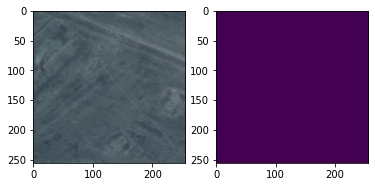

In [8]:
dataset.show_tuple(164)

# 2 Model

In [9]:
model_path = save_dir + "/" + model_name +  ".pth"
state_dict = torch.load(model_path,map_location="cpu")

In [10]:


if data_parallel:
    # create new OrderedDict that does not contain `module.`
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:] # remove `module.`
        new_state_dict[name] = v
    model_path = save_dir + "/" + model_name +  "_new.pth"
    torch.save(new_state_dict,model_path)
    

## 2.1 Advanced Unet

In [11]:
# Change here to adapt to your data
# n_channels=3 for RGB images 
# n_classes is the number of probabilities you want to get per pixel
if smp_model:
    net = smp.Unet(
        encoder_name="mit_b5",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=1,                      # model output channels (number of classes in your dataset)
    )
else:
    net = UNet(n_channels=3, n_classes=2, bilinear=False)
    #net= DataParallel(net)

if data_parallel:
    net.load_state_dict(new_state_dict)
else:
    net.load_state_dict(state_dict)
#net.load_state_dict(torch.load(model_path,map_location="cpu"))


#net= DataParallel(net,device_ids=[0,1])
net = net.to(device=device)




## 3 Validation

In [12]:
net.eval()
y_pred = torch.empty((len(dataset),256,256)).long()
start_idx = 0

with torch.no_grad(): 
    for i,batch in enumerate(test_dl):
        x = batch["x"]
        
        x = x.to(device)
        
        out = net(x)#["out"]
        
        if smp_model:
            probs = out.squeeze().sigmoid()
            out = (probs > 0.5).long().cpu()
        else:
            out = torch.argmax(out,dim=1)
            out = out.cpu()
            
        
        end_idx = start_idx + len(out)
        y_pred[start_idx:end_idx] = out
        start_idx += len(out)

In [13]:
dataset.evaluate(y_pred,model_name,save_dir=save_dir_output,
                 save_images=save_images,filter_true_empty=filter_true_empty);#,tmpdir="/tmp/test")

Model: smp_unet_mitb5_10_03_2023_091535
##############################
Year 2008: acc         0.974745
iou         0.031143
dice        0.058192
rmse_cov    0.023926
Number of patches: 9
Number of patches without filtering: 9
##############################
Year 2009: acc         0.958576
iou         0.254526
dice        0.365176
rmse_cov    0.012368
Number of patches: 49
Number of patches without filtering: 51
##############################
Year 2010: acc         0.954100
iou         0.204874
dice        0.292394
rmse_cov    0.023272
Number of patches: 38
Number of patches without filtering: 54
##############################
Year 2011: acc         0.994405
iou         0.024396
dice        0.037338
rmse_cov    0.004907
Number of patches: 28
Number of patches without filtering: 54
##############################
Year 2012: acc         0.995202
iou         0.000000
dice        0.000000
rmse_cov    0.004798
Number of patches: 12
Number of patches without filtering: 18
######################

# Results

Model: smp_unet_mitb407_03_2023_160548
##############################
Year 2008: acc         0.975462
iou         0.055961
dice        0.104601
rmse_cov    0.022998
Number of patches: 9
Number of patches without filtering: 9
##############################
Year 2009: acc         0.962915
iou         0.282843
dice        0.392175
rmse_cov    0.011083
Number of patches: 49
Number of patches without filtering: 51
##############################
Year 2010: acc         0.956755
iou         0.254998
dice        0.359019
rmse_cov    0.019358
Number of patches: 38
Number of patches without filtering: 54
##############################
Year 2011: acc         0.994730
iou         0.028526
dice        0.046929
rmse_cov    0.005163
Number of patches: 28
Number of patches without filtering: 54
##############################
Year 2012: acc         0.995202
iou         0.000000
dice        0.000000
rmse_cov    0.004798
Number of patches: 12
Number of patches without filtering: 18
##############################
Year 2013: acc         0.905305
iou         0.209357
dice        0.303708
rmse_cov    0.067461
Number of patches: 78
Number of patches without filtering: 84
##############################
Year 2014: acc         0.992581
iou         0.002883
dice        0.005415
rmse_cov    0.007307
Number of patches: 27
Number of patches without filtering: 45
##############################
Year 2015: acc         0.918941
iou         0.364619
dice        0.501853
rmse_cov    0.034943
Number of patches: 48
Number of patches without filtering: 51
##############################
Year 2016: acc         0.955641
iou         0.283282
dice        0.390860
rmse_cov    0.013074
Number of patches: 46
Number of patches without filtering: 55
##############################
Year 2017: acc         0.985392
iou         0.163221
dice        0.226763
rmse_cov    0.011786
Number of patches: 55
Number of patches without filtering: 248
##############################
Year 2018: acc         0.943191
iou         0.515059
dice        0.656421
rmse_cov    0.017197
Number of patches: 112
Number of patches without filtering: 180

##############################
Total score: acc         0.951055
iou         0.275808
dice        0.372530
rmse_cov    0.023904

Model: unet_01_12_2022_085945
##############################
Year 2008: acc         0.976323
iou         0.124094
dice        0.220447
rmse_cov    0.020143
Number of patches: 9
Number of patches without filtering: 9
##############################
Year 2009: acc         0.962267
iou         0.263771
dice        0.381754
rmse_cov    0.012544
Number of patches: 49
Number of patches without filtering: 51
##############################
Year 2010: acc         0.955448
iou         0.268630
dice        0.375675
rmse_cov    0.018961
Number of patches: 38
Number of patches without filtering: 54
##############################
Year 2011: acc         0.990753
iou         0.054420
dice        0.089359
rmse_cov    0.006695
Number of patches: 31
Number of patches without filtering: 54
##############################
Year 2012: acc         0.991206
iou         0.002802
dice        0.005524
rmse_cov    0.002955
Number of patches: 12
Number of patches without filtering: 18
##############################
Year 2013: acc         0.895146
iou         0.230822
dice        0.329517
rmse_cov    0.056147
Number of patches: 78
Number of patches without filtering: 84
##############################
Year 2014: acc         0.990684
iou         0.004437
dice        0.008521
rmse_cov    0.005234
Number of patches: 27
Number of patches without filtering: 45
##############################
Year 2015: acc         0.900973
iou         0.335352
dice        0.471045
rmse_cov    0.051464
Number of patches: 48
Number of patches without filtering: 51
##############################
Year 2016: acc         0.954090
iou         0.299281
dice        0.416734
rmse_cov    0.021372
Number of patches: 46
Number of patches without filtering: 55
##############################
Year 2017: acc         0.984948
iou         0.178381
dice        0.240246
rmse_cov    0.010387
Number of patches: 61
Number of patches without filtering: 248
##############################
Year 2018: acc         0.939113
iou         0.455215
dice        0.589907
rmse_cov    0.025544
Number of patches: 116
Number of patches without filtering: 180

##############################
Total score: acc         0.946750
iou         0.267270
dice        0.366211
rmse_cov    0.025884

Model: unet_18_11_2022_103158
##############################
Year 2008: acc         0.975020
iou         0.164834
dice        0.279420
rmse_cov    0.016836
Number of patches: 9
Number of patches without filtering: 9
##############################
Year 2009: acc         0.959878
iou         0.256571
dice        0.368672
rmse_cov    0.012577
Number of patches: 49
Number of patches without filtering: 51
##############################
Year 2010: acc         0.956784
iou         0.232050
dice        0.336251
rmse_cov    0.020028
Number of patches: 42
Number of patches without filtering: 54
##############################
Year 2011: acc         0.990908
iou         0.049234
dice        0.082808
rmse_cov    0.004890
Number of patches: 34
Number of patches without filtering: 54
##############################
Year 2012: acc         0.991881
iou         0.014205
dice        0.024948
rmse_cov    0.003058
Number of patches: 12
Number of patches without filtering: 18
##############################
Year 2013: acc         0.894301
iou         0.235356
dice        0.338554
rmse_cov    0.052674
Number of patches: 78
Number of patches without filtering: 84
##############################
Year 2014: acc         0.989871
iou         0.008965
dice        0.016982
rmse_cov    0.005148
Number of patches: 27
Number of patches without filtering: 45
##############################
Year 2015: acc         0.915778
iou         0.362730
dice        0.500502
rmse_cov    0.032636
Number of patches: 48
Number of patches without filtering: 51
##############################
Year 2016: acc         0.955506
iou         0.268793
dice        0.374870
rmse_cov    0.014433
Number of patches: 46
Number of patches without filtering: 55
##############################
Year 2017: acc         0.983712
iou         0.133131
dice        0.186424
rmse_cov    0.010085
Number of patches: 61
Number of patches without filtering: 248
##############################
Year 2018: acc         0.941828
iou         0.451156
dice        0.585788
rmse_cov    0.019439
Number of patches: 118
Number of patches without filtering: 180

##############################
Total score: acc         0.948707
iou         0.258357
dice        0.355813
rmse_cov    0.021372

Model: smp_unet_mitb3_09_03_2023_145642
##############################
Year 2008: acc         0.974982
iou         0.012057
dice        0.023406
rmse_cov    0.024814
Number of patches: 9
Number of patches without filtering: 9
##############################
Year 2009: acc         0.961518
iou         0.289327
dice        0.416569
rmse_cov    0.011349
Number of patches: 49
Number of patches without filtering: 51
##############################
Year 2010: acc         0.951858
iou         0.187828
dice        0.283354
rmse_cov    0.034544
Number of patches: 38
Number of patches without filtering: 54
##############################
Year 2011: acc         0.994741
iou         0.017159
dice        0.027681
rmse_cov    0.005020
Number of patches: 29
Number of patches without filtering: 54
##############################
Year 2012: acc         0.995001
iou         0.000000
dice        0.000000
rmse_cov    0.004716
Number of patches: 12
Number of patches without filtering: 18
##############################
Year 2013: acc         0.905893
iou         0.219610
dice        0.313560
rmse_cov    0.055534
Number of patches: 78
Number of patches without filtering: 84
##############################
Year 2014: acc         0.992568
iou         0.000000
dice        0.000000
rmse_cov    0.007432
Number of patches: 27
Number of patches without filtering: 45
##############################
Year 2015: acc         0.891617
iou         0.344034
dice        0.475327
rmse_cov    0.063758
Number of patches: 48
Number of patches without filtering: 51
##############################
Year 2016: acc         0.954184
iou         0.228123
dice        0.318736
rmse_cov    0.022082
Number of patches: 46
Number of patches without filtering: 55
##############################
Year 2017: acc         0.985158
iou         0.158539
dice        0.209537
rmse_cov    0.009388
Number of patches: 56
Number of patches without filtering: 248
##############################
Year 2018: acc         0.937495
iou         0.469689
dice        0.606651
rmse_cov    0.025403
Number of patches: 113
Number of patches without filtering: 180

##############################
Total score: acc         0.946737
iou         0.253486
dice        0.345374
rmse_cov    0.028315

Model: smp_unet_mitb3_08_03_2023_141120
##############################
Year 2008: acc     0.975235
iou     0.048314
dice    0.090734
Number of patches: 9
Number of patches without filtering: 9
##############################
Year 2009: acc     0.961634
iou     0.268784
dice    0.382104
Number of patches: 49
Number of patches without filtering: 51
##############################
Year 2010: acc     0.957270
iou     0.237080
dice    0.337079
Number of patches: 38
Number of patches without filtering: 54
##############################
Year 2011: acc     0.992470
iou     0.030290
dice    0.050277
Number of patches: 30
Number of patches without filtering: 54
##############################
Year 2012: acc     0.995202
iou     0.000000
dice    0.000000
Number of patches: 12
Number of patches without filtering: 18
##############################
Year 2013: acc     0.901802
iou     0.207323
dice    0.299950
Number of patches: 78
Number of patches without filtering: 84
##############################
Year 2014: acc     0.992189
iou     0.002177
dice    0.004219
Number of patches: 29
Number of patches without filtering: 45
##############################
Year 2015: acc     0.902300
iou     0.378573
dice    0.530991
Number of patches: 48
Number of patches without filtering: 51
##############################
Year 2016: acc     0.956777
iou     0.280676
dice    0.391447
Number of patches: 46
Number of patches without filtering: 55
##############################
Year 2017: acc     0.985178
iou     0.171618
dice    0.227436
Number of patches: 56
Number of patches without filtering: 248
##############################
Year 2018: acc     0.938939
iou     0.453341
dice    0.592626
Number of patches: 114
Number of patches without filtering: 180

##############################
Total score: acc     0.948203
iou     0.259590
dice    0.355924

Model: unet_05_03_2023_085814
##############################
Year 2008: acc     0.973735
iou     0.228177
dice    0.370914
Number of patches: 9
Number of patches without filtering: 9
##############################
Year 2009: acc     0.952701
iou     0.239594
dice    0.349972
Number of patches: 49
Number of patches without filtering: 51
##############################
Year 2010: acc     0.952197
iou     0.252481
dice    0.355735
Number of patches: 38
Number of patches without filtering: 54
##############################
Year 2011: acc     0.891780
iou     0.024571
dice    0.036572
Number of patches: 28
Number of patches without filtering: 54
##############################
Year 2012: acc     0.995271
iou     0.003190
dice    0.006144
Number of patches: 12
Number of patches without filtering: 18
##############################
Year 2013: acc     0.904791
iou     0.235476
dice    0.328283
Number of patches: 78
Number of patches without filtering: 84
##############################
Year 2014: acc     0.992557
iou     0.005921
dice    0.010876
Number of patches: 27
Number of patches without filtering: 45
##############################
Year 2015: acc     0.883709
iou     0.337167
dice    0.471826
Number of patches: 48
Number of patches without filtering: 51
##############################
Year 2016: acc     0.948975
iou     0.268447
dice    0.371404
Number of patches: 46
Number of patches without filtering: 55
##############################
Year 2017: acc     0.984042
iou     0.147874
dice    0.204366
Number of patches: 55
Number of patches without filtering: 248
##############################
Year 2018: acc     0.937651
iou     0.402810
dice    0.530216
Number of patches: 118
Number of patches without filtering: 180

##############################
Total score: acc     0.938487
iou     0.249682
dice    0.343583

In [14]:
dataset.evaluate(y_pred,model_name,save_dir=save_dir_output,
                 save_images=save_images,filter_true_empty=filter_true_empty);#,tmpdir="/tmp/test")

Model: unet_18_11_2022_103158
##############################
Year 2008: acc     0.975023
iou     0.164873
dice    0.279470
Number of patches: 9
Number of patches without filtering: 9
##############################
Year 2009: acc     0.959879
iou     0.256552
dice    0.368655
Number of patches: 49
Number of patches without filtering: 51
##############################
Year 2010: acc     0.956782
iou     0.232013
dice    0.336212
Number of patches: 42
Number of patches without filtering: 54
##############################
Year 2011: acc     0.990909
iou     0.049233
dice    0.082806
Number of patches: 34
Number of patches without filtering: 54
##############################
Year 2012: acc     0.991885
iou     0.014259
dice    0.025054
Number of patches: 12
Number of patches without filtering: 18
##############################
Year 2013: acc     0.894303
iou     0.235361
dice    0.338558
Number of patches: 78
Number of patches without filtering: 84
##############################
Year 2014: 

In [14]:
dataset.evaluate(y_pred,model_name,save_dir=save_dir_output,
                 save_images=save_images,filter_true_empty=filter_true_empty);#,tmpdir="/tmp/test")

Model: unet_01_12_2022_085728
##############################
Year 2008: acc     0.975632
iou     0.051503
dice    0.096448
Number of patches: 9
Number of patches without filtering: 9
##############################
Year 2009: acc     0.934967
iou     0.194369
dice    0.294822
Number of patches: 49
Number of patches without filtering: 51
##############################
Year 2010: acc     0.956814
iou     0.177748
dice    0.255432
Number of patches: 43
Number of patches without filtering: 54
##############################
Year 2011: acc     0.989650
iou     0.043771
dice    0.070365
Number of patches: 30
Number of patches without filtering: 54
##############################
Year 2012: acc     0.993196
iou     0.039779
dice    0.067133
Number of patches: 12
Number of patches without filtering: 18
##############################
Year 2013: acc     0.896603
iou     0.222982
dice    0.324649
Number of patches: 78
Number of patches without filtering: 84
##############################
Year 2014: 

In [14]:
dataset.evaluate(y_pred,model_name,save_dir=save_dir_output,
                 save_images=save_images,filter_true_empty=filter_true_empty);#,tmpdir="/tmp/test")

Model: unet_05_12_2022_150850
##############################
Year 2008: acc     0.975781
iou     0.063657
dice    0.119059
Number of patches: 9
Number of patches without filtering: 9
##############################
Year 2009: acc     0.964977
iou     0.247645
dice    0.357578
Number of patches: 49
Number of patches without filtering: 51
##############################
Year 2010: acc     0.957243
iou     0.189731
dice    0.277556
Number of patches: 41
Number of patches without filtering: 54
##############################
Year 2011: acc     0.992852
iou     0.036461
dice    0.060054
Number of patches: 34
Number of patches without filtering: 54
##############################
Year 2012: acc     0.992709
iou     0.032940
dice    0.057527
Number of patches: 12
Number of patches without filtering: 18
##############################
Year 2013: acc     0.898870
iou     0.189030
dice    0.266848
Number of patches: 78
Number of patches without filtering: 84
##############################
Year 2014: 

In [14]:
dataset.evaluate(y_pred,model_name,save_dir=save_dir_output,
                 save_images=save_images,filter_true_empty=filter_true_empty);#,tmpdir="/tmp/test")

Model: unet_25_11_2022_144326
##############################
Year 2008: acc     0.975679
iou     0.052279
dice    0.098039
Number of patches: 9
Number of patches without filtering: 9
##############################
Year 2009: acc     0.961093
iou     0.217797
dice    0.325556
Number of patches: 49
Number of patches without filtering: 51
##############################
Year 2010: acc     0.957178
iou     0.175184
dice    0.257441
Number of patches: 42
Number of patches without filtering: 54
##############################
Year 2011: acc     0.987002
iou     0.043230
dice    0.071179
Number of patches: 30
Number of patches without filtering: 54
##############################
Year 2012: acc     0.992874
iou     0.010094
dice    0.019401
Number of patches: 12
Number of patches without filtering: 18
##############################
Year 2013: acc     0.896581
iou     0.172528
dice    0.248793
Number of patches: 78
Number of patches without filtering: 84
##############################
Year 2014: 

In [14]:
dataset.evaluate(y_pred,model_name,save_dir=save_dir_output,
                 save_images=save_images,filter_true_empty=filter_true_empty);#,tmpdir="/tmp/test")

Model: unet_14_11_2022_123359
##############################
Year 2008: acc     0.975861
iou     0.102470
dice    0.182925
Number of patches: 9
Number of patches without filtering: 9
##############################
Year 2009: acc     0.958293
iou     0.222412
dice    0.335402
Number of patches: 49
Number of patches without filtering: 51
##############################
Year 2010: acc     0.955633
iou     0.175194
dice    0.259943
Number of patches: 41
Number of patches without filtering: 54
##############################
Year 2011: acc     0.991559
iou     0.073262
dice    0.117343
Number of patches: 28
Number of patches without filtering: 54
##############################
Year 2012: acc     0.991221
iou     0.026412
dice    0.048767
Number of patches: 12
Number of patches without filtering: 18
##############################
Year 2013: acc     0.894496
iou     0.188691
dice    0.287904
Number of patches: 78
Number of patches without filtering: 84
##############################
Year 2014: 

In [14]:
dataset.evaluate(y_pred,model_name,save_dir=save_dir_output,
                 save_images=save_images,filter_true_empty=filter_true_empty);#,tmpdir="/tmp/test")

Model: unet_16_11_2022_150616
##############################
Year 2008: acc     0.974740
iou     0.033447
dice    0.062821
Number of patches: 9
Number of patches without filtering: 9
##############################
Year 2009: acc     0.951485
iou     0.217822
dice    0.326155
Number of patches: 49
Number of patches without filtering: 51
##############################
Year 2010: acc     0.951416
iou     0.168444
dice    0.259965
Number of patches: 42
Number of patches without filtering: 54
##############################
Year 2011: acc     0.993130
iou     0.026732
dice    0.040791
Number of patches: 37
Number of patches without filtering: 54
##############################
Year 2012: acc     0.993797
iou     0.001205
dice    0.002375
Number of patches: 12
Number of patches without filtering: 18
##############################
Year 2013: acc     0.895734
iou     0.228239
dice    0.331870
Number of patches: 78
Number of patches without filtering: 84
##############################
Year 2014: 

In [14]:
dataset.evaluate(y_pred,model_name,save_dir=save_dir_output,
                 save_images=save_images,filter_true_empty=filter_true_empty);#,tmpdir="/tmp/test")

Model: unet_16_11_2022_150534
##############################
Year 2008: acc     0.974899
iou     0.007937
dice    0.014815
Number of patches: 9
Number of patches without filtering: 9
##############################
Year 2009: acc     0.961376
iou     0.164572
dice    0.257760
Number of patches: 49
Number of patches without filtering: 51
##############################
Year 2010: acc     0.944781
iou     0.033545
dice    0.060148
Number of patches: 42
Number of patches without filtering: 54
##############################
Year 2011: acc     0.993933
iou     0.044683
dice    0.071010
Number of patches: 28
Number of patches without filtering: 54
##############################
Year 2012: acc     0.994367
iou     0.002604
dice    0.005051
Number of patches: 12
Number of patches without filtering: 18
##############################
Year 2013: acc     0.890455
iou     0.149594
dice    0.236377
Number of patches: 78
Number of patches without filtering: 84
##############################
Year 2014: 

In [14]:
dataset.evaluate(y_pred,model_name,save_dir=save_dir_output,
                 save_images=save_images,filter_true_empty=filter_true_empty);#,tmpdir="/tmp/test")

Model: unet_11_07_2022_070457_new
##############################
Year 2008: acc     0.974777
iou     0.010356
dice    0.019972
Number of patches: 9
Number of patches without filtering: 9
##############################
Year 2009: acc     0.944657
iou     0.175323
dice    0.270928
Number of patches: 49
Number of patches without filtering: 51
##############################
Year 2010: acc     0.958483
iou     0.184294
dice    0.266584
Number of patches: 42
Number of patches without filtering: 54
##############################
Year 2011: acc     0.991826
iou     0.031329
dice    0.049057
Number of patches: 30
Number of patches without filtering: 54
##############################
Year 2012: acc     0.994549
iou     0.000446
dice    0.000888
Number of patches: 12
Number of patches without filtering: 18
##############################
Year 2013: acc     0.897386
iou     0.211412
dice    0.306330
Number of patches: 78
Number of patches without filtering: 84
##############################
Year 20

In [14]:
dataset.evaluate(y_pred,model_name,save_dir=save_dir_output,
                 save_images=save_images,filter_true_empty=filter_true_empty);#,tmpdir="/tmp/test")

Model: unet_14_11_2022_170422
##############################
Year 2008: acc     0.974786
iou     0.001523
dice    0.003027
Number of patches: 9
Number of patches without filtering: 9
##############################
Year 2009: acc     0.958871
iou     0.085848
dice    0.139820
Number of patches: 49
Number of patches without filtering: 51
##############################
Year 2010: acc     0.937228
iou     0.003200
dice    0.006307
Number of patches: 39
Number of patches without filtering: 54
##############################
Year 2011: acc     0.993436
iou     0.001129
dice    0.002236
Number of patches: 33
Number of patches without filtering: 54
##############################
Year 2012: acc     0.994954
iou     0.002284
dice    0.004436
Number of patches: 13
Number of patches without filtering: 18
##############################
Year 2013: acc     0.876864
iou     0.068803
dice    0.112788
Number of patches: 78
Number of patches without filtering: 84
##############################
Year 2014: 

In [15]:
dataset.evaluate(y_pred,model_name,save_dir=save_dir_output,
                 save_images=save_images,filter_true_empty=filter_true_empty);#,tmpdir="/tmp/test")

Model: unet_10_11_2022_113229
##############################
Year 2008: acc     0.974759
iou     0.016718
dice    0.032115
Number of patches: 9
Number of patches without filtering: 9
##############################
Year 2009: acc     0.932932
iou     0.131003
dice    0.213901
Number of patches: 49
Number of patches without filtering: 51
##############################
Year 2010: acc     0.944381
iou     0.122129
dice    0.198711
Number of patches: 38
Number of patches without filtering: 54
##############################
Year 2011: acc     0.954805
iou     0.024314
dice    0.044842
Number of patches: 28
Number of patches without filtering: 54
##############################
Year 2012: acc     0.993984
iou     0.000000
dice    0.000000
Number of patches: 12
Number of patches without filtering: 18
##############################
Year 2013: acc     0.864804
iou     0.167346
dice    0.268004
Number of patches: 78
Number of patches without filtering: 84
##############################
Year 2014: 

## With resampling


In [14]:
dataset.evaluate(y_pred,model_name,save_dir=save_dir_output,
                 save_images=save_images,filter_true_empty=filter_true_empty);#,tmpdir="/tmp/test")

Model: unet_16_11_2022_150616
##############################
Year 2008: acc     0.956565
iou     0.268837
dice    0.419315
Number of patches: 36
Number of patches without filtering: 36
##############################
Year 2009: acc     0.950088
iou     0.211725
dice    0.324700
Number of patches: 199
Number of patches without filtering: 204
##############################
Year 2010: acc     0.936889
iou     0.237397
dice    0.341019
Number of patches: 177
Number of patches without filtering: 216
##############################
Year 2011: acc     0.987077
iou     0.065068
dice    0.106866
Number of patches: 108
Number of patches without filtering: 216
##############################
Year 2012: acc     0.991014
iou     0.063488
dice    0.096181
Number of patches: 30
Number of patches without filtering: 72
##############################
Year 2013: acc     0.869233
iou     0.240253
dice    0.361520
Number of patches: 272
Number of patches without filtering: 336
##############################
Y

In [14]:
dataset.evaluate(y_pred,model_name,save_dir=save_dir_output,
                 save_images=save_images,filter_true_empty=filter_true_empty);#,tmpdir="/tmp/test")

Model: unet_16_11_2022_150534
##############################
Year 2008: acc     0.975344
iou     0.045082
dice    0.083497
Number of patches: 36
Number of patches without filtering: 36
##############################
Year 2009: acc     0.960779
iou     0.156735
dice    0.248321
Number of patches: 194
Number of patches without filtering: 204
##############################
Year 2010: acc     0.948710
iou     0.129528
dice    0.204030
Number of patches: 159
Number of patches without filtering: 216
##############################
Year 2011: acc     0.990656
iou     0.040197
dice    0.066201
Number of patches: 83
Number of patches without filtering: 216
##############################
Year 2012: acc     0.982156
iou     0.012028
dice    0.020909
Number of patches: 27
Number of patches without filtering: 72
##############################
Year 2013: acc     0.870716
iou     0.182134
dice    0.286300
Number of patches: 268
Number of patches without filtering: 336
##############################
Ye